In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import altair as alt
alt.data_transformers.enable('json')
#alt.renderers.enable('notebook')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn import preprocessing
import numpy as np
from sklearn.metrics import accuracy_score, plot_confusion_matrix, confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import recall_score, precision_score
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import SMOTE
from docopt import docopt
from sklearn.feature_selection import RFECV

# Data description

The dataset we are analyzing is from [UCI machine learning repository](https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients). It's about customers default payments in Taiwan, if the customer will fail to pay in October 2005(`DEFAULT_NEXT_MONTH`). There are 30,000 instances in total and 23 exploratory variables about customers' payment, bill histories and demographic factors. Details are as below according to the data description from UCI,

- `LIMIT_BAL`: Amount of the given credit (NT dollar): it includes both the individual consumer credit and his/her family (supplementary) credit. 
- `SEX`: Gender(1 = male; 2 = female).
- `EDUCATION`: Education (1 = graduate school; 2 = university; 3 = high school; 4 = others). 
- `MARRIAGE`: Marital status (1 = married; 2 = single; 3 = others).  
- `AGE`: Age (year).  
- `PAY_1`, `PAY_2`, ..., `PAY_6`: Past monthly repayment status in September 2005, August 2005, ..., April 2005 respectively. ( -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 8 = payment delay for eight months; 9 = payment delay for nine months and above.)  
- `BILL_AMT1`, `BILL_AMT2`, ..., `BILL_AMT6`: Amount of bill statement (NT dollar) in September 2005, August 2005, ..., April 2005 respectively.  
- `PAY_AMT1`, `PAY_AMT2`, ..., `PAY_AMT6`: Amount of previous payment (NT dollar) in September 2005, August 2005, ..., April 2005 respectively.  

We are interested to build a good model to predict if the customers will default in the next month which is in October 2005 accurately and thus find out what features strongly predict default payment from the model.

# Read in the data

In [27]:
df = pd.read_csv("../data/cleaned-credit-default-data.csv", index_col=0)
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
ID,,,,,,,,,,,,,,,,,,,,,
1,20000,2,2,1,24,2,2,-1,-1,-2,...,0,0,0,0,689,0,0,0,0,1
2,120000,2,2,2,26,-1,2,0,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
3,90000,2,2,2,34,0,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
4,50000,2,2,1,37,0,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
5,50000,1,2,1,57,-1,0,-1,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


# Data overview

According to the above table, we can see mean, standard deviation, min, max etc. The bill amount, payment amount and credit limit ranges are roughly similar which are around 800,000. It's interesting that The medians for the bill statement amounts are around 20,000, but the medians for payment amounts are 2,000. Age ranges from 21 to 75 which is reasonable.

However, there are so many negative numbers for bill amount. Let's see if that's some kind of errors. Below I pulled some rows that have negative values at `BILL_AMT6'.

According to the table, the customer paid big amount at that month for some reason, but the amount matches basically.

One issue with the dataset is that there are many entries under repayment status columns of values 0 These values should be considered N/A. 

There are several options we can choose to deal with these missing values. We could omit the rows with 0 values and just focus our analysis on the 52% of data. Since the 0 values represent a big portion of the data, and because the missing values may not be random we may also choose to use those N/A rows by classifying the missing data as N/A rather than 0.

### Categorical features  
How many people are in each class of each categorical feature? Bar chart is easy to compare the difference.  
For example, from the following plots, for Count of SEX(gender) we can see class 2 - Female is almost twice the number of the class 1 - Male.

There are lots of 0s for `PAY_1`, `PAY_2`, ..., `PAY_6` which are past monthly status. 0 is not documented in the original data description. I guess it probably means "unknown". But because we are fitting the prediction model, we don't really need to know the meaning of 0. It's still some sort of the information about the status, so we'll leave as is.

### The response variable  
The response variable has two classes. 1 - Default payment is about a third of 0 - Non default. It's imbalanced dataset, but there are still around 5000 examples for default payment to train the model, I don't think it's too bad.

# Possible relationships  
Let's see if we can find some relationships or patterns through plots, so that it makes sense to predict based on these predictor variables.  

### Correlations among numeric predictors  
Collinearity among predictors would be a problem for some models, for example, logistic regression. If they are strongly correlated, the weights we get from the fitted logistic regression model cannot be trusted.  
According to the below plot, bill statement amounts are highly correlated. It makes sense, because the amount owed this month is dependent on the amount owed from last month. So we might need to drop some columns when fitting the model or choose the model that won't be affected by the collinearity of predictors. Other than that, payment amounts, bill statement amounts and age are relatively independent of each other.

In [18]:
##TOO SLOW to run

#num_corr = alt.Chart(X_train).mark_circle().encode(
#     alt.X(alt.repeat('column'), type='quantitative'),
#     alt.Y(alt.repeat('row'), type='quantitative')
# ).properties(width=150, height=150).repeat(
#     row=numeric_features,
#     column=numeric_features
# )

### Possible relationships between categorical and numeric predictors  

If one class of the categorical feature amount is consistently higher than some other class of the categorical feature. For example, if women tend to have higher credit limit than men. Because the distribution of bill statement amounts and payment amounts are similar among different months, I selected one of them randomly to draw the graphs.  

For example, we can see that education probably influences the credit limit, because 3-high school boxplot is lower than 4-Others boxplot.

### Possible relationships between predictors and the response variable  

Our research question is what features predict default payment? Let's see if we can find any strong associations between predictors and the response variable visually.

- Numeric predictors to the response variable  
According to the boxplots below, credit limit for 0-Non default is slightly higher than 1-default. It's probably a good predictor for default payment. It also makes sense because for people able to get higher credit limit, they must have good credit history, so that banks are willing to allow them higher credit amount. Also, payment amounts seem are also good predictors to me, because non default tends to have higher and more higher outliers than default payment.

- Categorical predictors to the response variable  
According to the below graphs, gender, education and marriage's proportions of different classes are pretty similar between non default and default payment. For payment status, 2-payment delay for two months accounted for more in 1-default payment than in 0-non default. Therefore, they are probably good predictor variables to predict default payment as well.

# Analyisis

### 1. Model Selection

According to the above exploratory data analysis, I think the data entries are reasonable and valid. Data size is good enough for fitting models.

We see collinearity between `BILL_AMT1`, `BILL_AMT2`, ..., `BILL_AMT6` variables. We should consider that when fitting the prediction models. According to the plots, `LIMIT_BAL`, `PAY_AMT1`, `PAY_AMT2`, ..., `PAY_AMT6`, `PAY_1`, `PAY_2`, ..., `PAY_6` are probably good predictor variables to predict if customers will fail to pay next month or not.

Overall, this would be a good dataset to fit the model and to predict the default payment. And "What features strongly predict default payment?" is a good and interesting research question for this dataset.

 ### 2. Results

First , let us check the `Evaluation Matrix`

In [33]:
evaluation_matrix = pd.read_csv("../results/accuracies.csv")
evaluation_matrix


,Unnamed: 0,result
0,test accuracy,0.687200
1,train accuracy,0.684844
2,test recall,0.658610
3,test precision,0.379659
4,auc-score,0.723004


Now, let us check the `ROC`


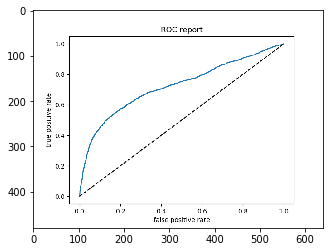

In [25]:
roc_plot = plt.imread("../results/roc.png")
plt.imshow(roc_plot);

Below is the the `classification_report`


In [37]:
classification_report = pd.read_csv("../results/classification_report.csv")
classification_report


,Unnamed: 0,0,1,accuracy,macro avg,weighted avg
0,precision,0.877943,0.379659,0.6872,0.628801,0.767989
1,recall,0.695295,0.658610,0.6872,0.676953,0.687200
2,f1-score,0.776017,0.481662,0.6872,0.628839,0.711062
3,support,5845.000000,1655.000000,0.6872,7500.000000,7500.000000


# References

1. 

2.

3.